# Setup

## Imports

In [1]:
import pickle

from vaiutils import path_consts, plot_images, smooth_plot
from glob import glob
from scipy.misc import imread, imresize
from tqdm import tqdm_notebook
from os.path import exists

Keras Modules

In [2]:
import keras.backend as K

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, SimpleRNN, Lambda, Dense, TimeDistributed
from keras.backend import clear_session
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras_tqdm import TQDMNotebookCallback

Using TensorFlow backend.


## Define useful variables and functions

In [64]:
for k, v in path_consts(['COCO', 'SampleImages'], 'Simple'):
    exec(k + '=v')

In [4]:
def pickle_load(filename, path=None, default=None):
    if path is None:
        path = DIR_CHECKPOINTS
    if exists(path + '/' + filename + '.p'):
        with open(path + '/' + filename + '.p', 'rb') as f:
            return pickle.load(f)
    else:
        assert default is not None, "File not found! Provide a default instead"
        return default

In [5]:
def pickle_dump(filename, obj, path=None):
    if path is None:
        path = DIR_CHECKPOINTS
    with open(path + '/' + filename + '.p', 'wb') as f:
        return pickle.dump(obj, f)

# Load Data

VGG Net

In [6]:
vgg_mean = np.array([123.68, 116.779, 103.939])


def preprocess_input(x): return (x - vgg_mean)[:, :, :, ::-1]

In [7]:
clear_session()
vgg = VGG16(input_tensor=Lambda(
    preprocess_input)(Input((224, 224, 3))))
vgg = Model(vgg.input, vgg.layers[-2].output)
for layer in vgg.layers:
    layer.trainable = False
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
__________

In [8]:
filenames = sorted(glob(DIR_DATA['COCO'] + '/val2017/*.jpg'))

In [28]:
tokenizer = pickle_load('simple_tokenizer', path=DIR_DATA['COCO'])
captions = pickle_load('simple_captions', path=DIR_DATA['COCO'])

In [29]:
captions = list(captions.values())

In [31]:
seq_length = 20

In [32]:
captions = [pad_sequences(caption, seq_length,
                         padding='post', truncating='post') for caption in captions]

In [33]:
word_idx = tokenizer.word_index
word_idx[''] = 0

In [34]:
idx_word = {v: k for k, v in word_idx.items()}

In [35]:
vocab_size = tokenizer.num_words

In [37]:
frac_val = 0.01
len_train = int((1 - frac_val) * len(filenames))

In [38]:
data = np.zeros((len(filenames), 4096))
for i, filename in enumerate(tqdm_notebook(filenames[:len_train])):
    image = imresize(imread(filename), (224, 224))
    if len(image.shape) == 2:
        image = np.repeat(np.expand_dims(image, 2), 3, 2)
    data[i] = vgg.predict(np.expand_dims(image, 0))

In [39]:
val_data = data[len_train:]
data = data[:len_train]
val_captions = captions[len_train:]
captions = captions[:len_train]

In [40]:
val_captions = [caption[randint(0, 5)] for caption in val_captions]

In [41]:
def get_captions(caption_ids):
    if type(caption_ids) is not list:
        caption = ' '.join(idx_word[i] for i in caption_ids).rstrip()
        stop_idx = caption.find('.')
        return caption[:stop_idx - 1] if stop_idx != -1 else caption

    return [get_captions(idx) for idx in caption_ids]

In [42]:
class DataGenerator():
    def __init__(self, batch_size=32, shuffle=True, target_size=(224, 224)):
        self.images_seen = 0
        self.total_images = len_train
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.target_size = target_size

    def generate(self):
        while True:
            caption_arrays = np.zeros((self.batch_size, seq_length))
            if self.shuffle:
                img_idx = randint(0, self.total_images, self.batch_size)
            else:
                img_idx = range(self.images_seen,
                                self.images_seen + self.batch_size)

            for i, idx in enumerate(img_idx):
                caption_arrays[i] = captions[idx][randint(0, 5)]
                self.images_seen += 1

            if self.images_seen + self.batch_size >= self.total_images:
                self.images_seen = 0

            yield([data[img_idx], np.zeros((self.batch_size, seq_length))], np.expand_dims(caption_arrays, -1))

In [43]:
generator = DataGenerator()

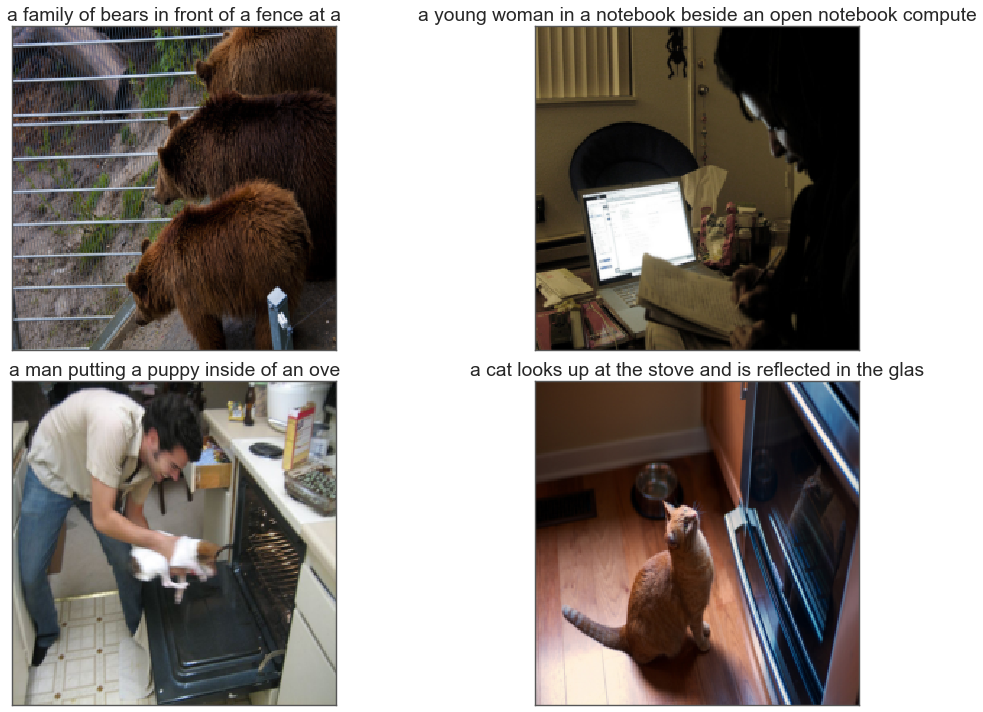

In [58]:
img_idx = randint(0, len_train, 4)
sample_img = []
sample_captions = []
for img_id in img_idx:
    sample_img.append(imresize(imread(filenames[img_id]), (224, 224)))
    sample_captions.append(captions[img_id][randint(0, 5)])
plot_images(sample_img, get_captions(sample_captions), merge_shape=None)

# Create Model

In [59]:
def get_model(num_hidden=1024):
    img_in = Input([4096], name='img_in')
    dummy = Input([seq_length], name='dummy')

    img_code = Dense(num_hidden, activation='relu', name='img_code')(img_in)

    dummy_embed = Embedding(
        vocab_size, num_hidden, input_length=seq_length, name='dummy_embed')(dummy)
    lstm_layer = SimpleRNN(num_hidden, return_sequences=True, name='lstm_layer')(
        dummy_embed, initial_state=img_code)
    cap_out = Dense(vocab_size, activation='softmax',
                    name='cap_out')(lstm_layer)

    model = Model([img_in, dummy], cap_out)
    model.compile('adam', 'sparse_categorical_crossentropy')
    return model

In [97]:
model = get_model()
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dummy (InputLayer)               (None, 20)            0                                            
____________________________________________________________________________________________________
img_in (InputLayer)              (None, 4096)          0                                            
____________________________________________________________________________________________________
dummy_embed (Embedding)          (None, 20, 1024)      2048000     dummy[0][0]                      
____________________________________________________________________________________________________
img_code (Dense)                 (None, 1024)          4195328     img_in[0][0]                     
___________________________________________________________________________________________

# Train Model

In [61]:
def handle_weights(load=True):
    global model
    if load and exists(DIR_CHECKPOINTS + '/weights.h5'):
        model.load_weights(DIR_CHECKPOINTS + '/weights.h5')
    elif not load:
        model.save_weights(DIR_CHECKPOINTS + '/weights.h5')
        model.save_weights(DIR_CHECKPOINTS + '/last/weights.h5')

In [66]:
def fit_model(epochs=1, lr=1e-3):
    global model
    model.optimizer.lr = lr

    history = pickle_load('history', default={})
    handle_weights()
    hist = model.fit_generator(generator.generate(), int(generator.total_images / generator.batch_size),
                               epochs=epochs, verbose=0, callbacks=[TQDMNotebookCallback(show_inner=False)], validation_data=([val_data, np.zeros((len(filenames)-len_train, seq_length))], np.expand_dims(val_captions, -1)))

    for k, v in hist.history.items():
        if k not in history.keys():
            history[k] = []
        history[k] += hist.history[k]

    pickle_dump('history', history)
    pickle_dump('history', history, path=DIR_CHECKPOINTS+'/last')
    handle_weights(load=False)

    smooth_plot(history)

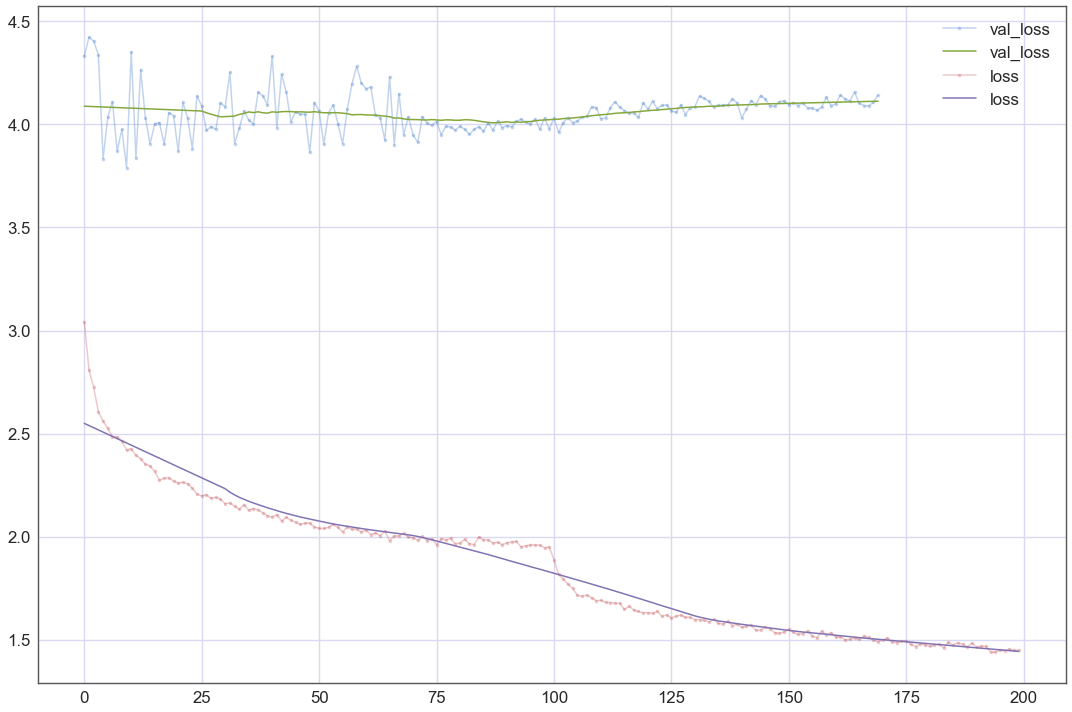

In [98]:
fit_model(100, 1e-4)

# Test Model

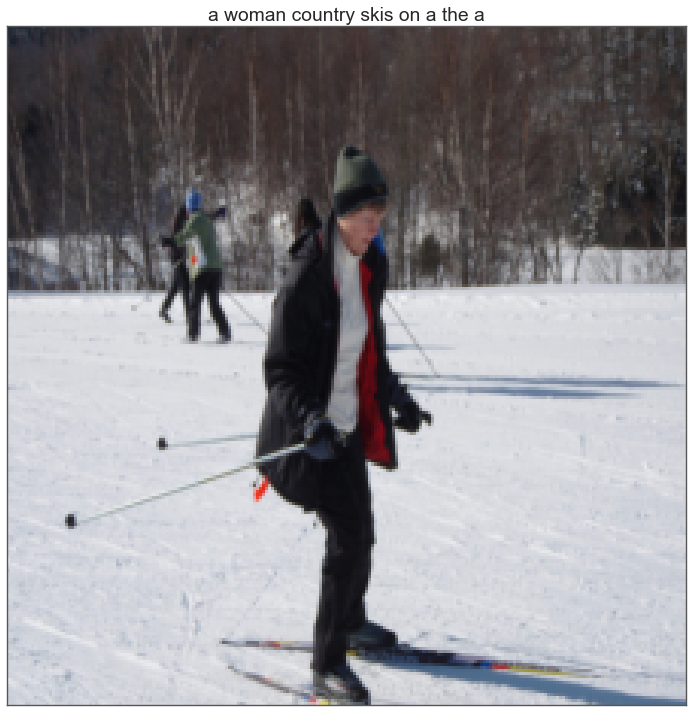

In [139]:
sample_image = imresize(imread(filenames[randint(len_train, len(filenames))]), (224, 224))
#sample_image = imresize(imread(DIR_DATA['SampleImages']+'/modi.jpg'), (224, 224))
sample_caption = model.predict([vgg.predict(np.expand_dims(
    sample_image, 0)), np.zeros((1, seq_length))])[0].argmax(1)
plot_images([sample_image], get_captions(sample_caption))